In [50]:
import mdtraj as md
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from scipy.signal import find_peaks




from ele import element_from_symbol

# More advanced h-bond analysis

For the multilayer membranes, it's not sufficient simply to calculate the hydrogen bonds for the system as a whole.  We typically want to breakdown the calculation by location in the direciton parallel to the membrane normal, or further by which ceramide molecules are extended and those that are hairpin. 

To achieve this we will need to parse the trajectory to define new index groups that correspond to each of these breakdowns before calling the code in the `simple_hbond_calculation.ipynb` example.  
* It is important to note that the groups defined in the index file are static.  As such, if the system were changing through time, we'd need to regenerate the index file periodically through time and pass a start and end time (corresponding to the index file) to GROMACS when calling the hbond command.   However, since the dense membranes we are considering here do not change much as a function of time, we can simply define this index file once.  

To break up the system and define the new index file, we will create a simple class that stores information about each lipid, and allows us to quickly calculate things such as lipid tail center-of-mass and identifies which lipids are hairpin and which are extended. We will use the code in the `networkx_example.ipynb` to allows to automate the identification of each tail in the ceramide lipids.  

## Lipid data storage class:

Let us now define a simple data storage class called lipid. Note this will assume that the trajectory has had PBC undone. 

In [112]:
#a data container class to make it easier to query the system than mdtraj's datastructure
# in particular, this will allow me to calculate com of each lipid, including separately consider
# each tail in the CERs and identify hairpin vs. extended

class Lipid:
    def __init__(self, name, res_id):
        self.name = name
        self.atom_xyz = []
        self.atom_index = []
        self.atom_element = []
        self.res_id = res_id
        self.com = []
        self.is_hairpin = True

        self.com1 = []  #if we are a two chain lipid, we will also calculate com of each chain
        self.com2 = []
        self.headgroup_com = []
        self.carbons_chain1 = [] #if we are a two chain lipid, we need to know which indices to consider
        self.carbons_chain2 =[]
        self.headgroup = []
        self.cer_graph = nx.Graph() 
        self.angle = 0
        
        self.calc_com_performed = False
        self.calc_tails_performed = False


    #set up arays that store the pattern for each chain
    def add_atom(self, xyz, element, index):
        self.atom_xyz.append(np.array(xyz))
        # often the element name has a digit appended to it
        # while useful for identifing atoms within the molecule, we don't need it and 
        # actually need to remove to to identify the mass
        element_stripped = "".join(filter(lambda x: not x.isdigit(), element))
        self.atom_element.append(element_stripped)
        self.atom_index.append(index)
    
    def calc_tails(self):
                
        #loop over all C-C and C-H particle pairs in the residue
        for i in range(0, len(self.atom_xyz)):
            if self.atom_element[i] == 'C':
                for j in range(i+1, len(self.atom_xyz)):
                    if self.atom_element[j] == 'C' or self.atom_element[j] == 'H':
                        #note we are assuming we have an unwrapped trajectory
                        dist = np.linalg.norm(self.atom_xyz[j]-self.atom_xyz[i])
                        if dist < 0.18:
                            self.cer_graph.add_edge(i,j) #note we will use relative indices in the residue
                            
        chain_ids = []

        for c in nx.connected_components(self.cer_graph):                
            chain_temp = []
            for node in self.cer_graph.subgraph(c).nodes:
                # first let us consider the C-backbone atoms
                if 'C' in self.atom_element[node]:
                    connections = self.cer_graph.edges(node)
                    #only consider those with 4 connections
                    if len(connections) == 4:
                        C_count = 0
                        H_count = 0
                        for connection in connections:
                            temp_id = connection[1] #who we are connected to is the second element
                            if 'H' in self.atom_element[temp_id]:
                                H_count = H_count + 1
                            elif 'C' in self.atom_element[temp_id]:
                                C_count = C_count + 1
                        #we specified we need 4 connections and that they need to be either [C][C][H][H] or [C][H][H][H]
                        if C_count >= 1 and H_count == 2:
                            chain_temp.append(node) #add the base carbon to the list of atoms

                            for connection in connections:
                                temp_id = connection[1]
                                #note only add the hydrogen atoms since we looping over all Carbons already
                                if 'H' in self.atom_element[temp_id]:
                                    chain_temp.append(connection[1])
                                    
            chain_ids.append(chain_temp) 
                
        if len(chain_ids) == 2:
            self.carbons_chain1 = chain_ids[0]
            self.carbons_chain2 = chain_ids[1]
        else:
            print("Expected two tails for cer, but we identified: ", len(chain_ids))
        for i in range(0, len(self.atom_xyz)):
            if i not in self.carbons_chain1:
                if i not in self.carbons_chain2:
                    self.headgroup.append(i)

        self.calc_tails_performed = True

                          
    def calc_com(self):
        temp_pos = [0,0,0] 
        norm = 0
        for i in range(0, len(self.atom_element)):
            temp_mass = element_from_symbol(self.atom_element[i]).mass
            norm = norm + temp_mass
            for j in range(0,3):
                temp_pos[j] = temp_pos[j] + temp_mass * self.atom_xyz[i][j]
        
        for j in range(0,3):
            temp_pos[j] = temp_pos[j]/(norm)
        self.com = temp_pos
        if self.name == 'ucer2':
            #make sure we have identified the tails 
            # call the function if we haven't yet
            if self.calc_tails_performed == False:
                self.calc_tails()
            temp_pos1 = [0,0,0] 
            norm = 0
            for i in range(0, len(self.carbons_chain1)):
                ii = self.carbons_chain1[i]
                temp_mass = element_from_symbol(self.atom_element[ii]).mass
                norm = norm + temp_mass
                for j in range(0,3):
                    temp_pos1[j] = temp_pos1[j] + temp_mass * self.atom_xyz[ii][j]
        
            for j in range(0,3):
                temp_pos1[j] = temp_pos1[j]/(norm)
            self.com1 = temp_pos1
            
            temp_pos2 = [0,0,0] 
            norm = 0
            for i in range(0, len(self.carbons_chain2)):
                ii = self.carbons_chain2[i]
                temp_mass = element_from_symbol(self.atom_element[ii]).mass
                norm = norm + temp_mass
                for j in range(0,3):
                    temp_pos2[j] = temp_pos2[j] + temp_mass * self.atom_xyz[ii][j]
        
            for j in range(0,3):
                temp_pos2[j] = temp_pos2[j]/(norm)
            self.com2 = temp_pos2
            
            temp_pos3 = [0,0,0] 
            norm = 0
            for i in range(0, len(self.headgroup)):
                ii = self.headgroup[i]
                temp_mass = element_from_symbol(self.atom_element[ii]).mass
                norm = norm + temp_mass
                for j in range(0,3):
                    temp_pos3[j] = temp_pos3[j] + temp_mass * self.atom_xyz[ii][j]
        
            for j in range(0,3):
                temp_pos3[j] = temp_pos3[j]/(norm)
            self.headgroup_com = temp_pos3
        self.calc_com_performed = True
    
    # mdtraj/mbuild/vmd all like nm as their unit; vmd does angstroms, so often useful to convert
    def scale_com(self, factor=10.0):    
        for j in range(0,3):
            self.com[j] = self.com[j]*factor
            if self.name == 'ucer2':
                self.com1[j] = self.com1[j]*factor
                self.com2[j] = self.com2[j]*factor

    def check_hairpin(self): 
        if self.calc_com_performed == False:
            self.calc_com()

        temp1 = np.array(self.com1)- np.array(self.headgroup_com)
        temp2 = np.array(self.com2)- np.array(self.headgroup_com)
        
        uv_1 = temp1/np.linalg.norm(temp1)
        uv_2 = temp2/np.linalg.norm(temp2)

        dp = np.dot(uv_1, uv_2)
        self.angle = np.arccos(dp)
        
        #hairpin if greater than 90
        if self.angle > 3.14/2:
            self.is_hairpin = False

We can then load up the trajectory and put the first frame into the lipid class to do the appropriate breakdown.

In [33]:
traj = md.load('../../4_prod_f305/trimmed_470.xtc', 
            top='../../4_prod_f305/confout.gro')

In [129]:
n_frames1 = 1
lipids = []
total_lipids = 0

chain_id = 0
cer_id= 0
res_id = 0
for residue in traj[0].topology.residues:
    temp_lipid = Lipid(residue.name,res_id)
    for atom in residue.atoms:
        temp_lipid.add_atom(traj.xyz[0,atom.index,:],atom.name, atom.index)
    if 'cer' in residue.name:
        temp_lipid.calc_tails()
        temp_lipid.check_hairpin()
    temp_lipid.calc_com()
    lipids.append(temp_lipid)
    res_id = res_id+1

## Breaking up the system: identifying bounds

To breakup the system by location in the z-direction (i.e., normal to the membrane), we will calculate a histogram of the position of tail COM in the z-direction (i.e., normal to the membrane interface).   We could use this histogram to manually select values, but in the spirit of automation we will use the signal processing library to identify the peaks, and then just simply choose the midpoints between those peaks. 

Let us first create an array that contains all of the COM from the lipids.  Note that we will consider the two tails separately for the ceramides. 

In [130]:
all_coms = []
for lipid in lipids:
    if lipid.name == 'ucer2':
        all_coms.append(lipid.com1[2])
        all_coms.append(lipid.com2[2])
    elif lipid.name == 'chol':
        all_coms.append(lipid.com[2])
    elif lipid.name == 'ffa24':
        all_coms.append(lipid.com[2])

Calculate the histogram and plot it. 

Text(0, 0.5, 'counts')

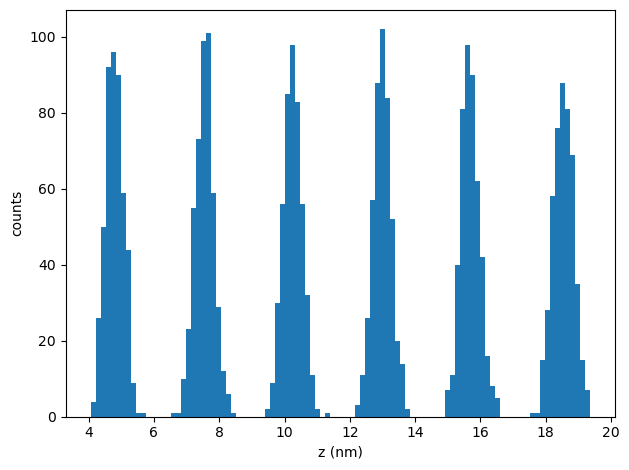

In [131]:
n_bins=100
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

com_hist = axs.hist(all_coms, bins=n_bins)
axs.set_xlabel('z (nm)')
axs.set_ylabel('counts')

We will next use the signal processing library to find the peaks and print these to the screen.  The value of height is just allows us to eliminate anything below that value (avoid any minor peaks). This value will depend upon the number of samples (if unnormalized) and the bin size.  


Given this system has 6 layers, we would expect there to be six peaks, if we print out `peaks`.  
* Note the output of `peaks` correspond to indices of the `com_hist`, not their numerical values. We have to pass this to `com_hist` to get the actual z value.

In [132]:
peaks, _ = find_peaks(com_hist[0][:], height=80)


print(peaks)
print("\nActual position in z:\n------")
for peak in peaks: print(com_hist[1][peak])

[ 4 23 40 58 75 94]

Actual position in z:
------
4.681353920808348
7.583561364447384
10.180273287703361
12.92973297115087
15.526444894406849
18.428652338045882


Identify the midpoints to be used as cutoffs and then plot these to make sure visually things look good:

In [133]:
n_bounds_min = []
n_bounds_max = []

for i in range(0, len(peaks)-1):
    
    temp =  (com_hist[1][peaks[i+1]] - com_hist[1][peaks[i]])*0.5 + com_hist[1][peaks[i]] 
    n_bounds_min.append(temp)

for bound in n_bounds_min: print(bound)

6.132457642627866
8.881917326075373
11.555003129427115
14.22808893277886
16.977548616226365


(0.0, 120.0)

<Figure size 1750x1050 with 0 Axes>

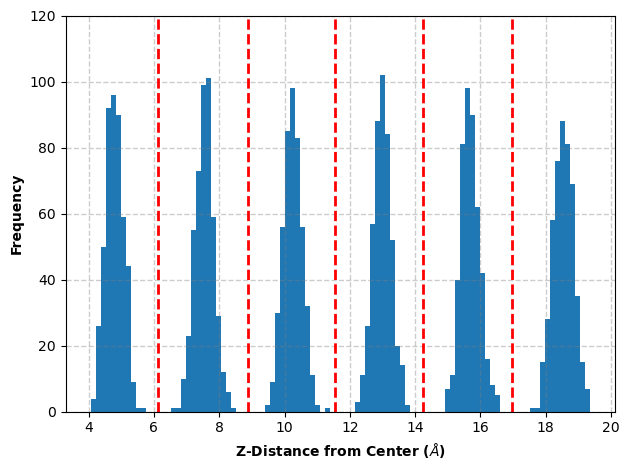

In [134]:
plt.rcdefaults()
plt.figure(dpi=350, figsize=(5, 3))
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

axs.grid(color='grey', linestyle='--', linewidth=1, alpha=0.4)

com_hist = axs.hist(all_coms, bins=n_bins)


arbitrary_max = 120
for i in range(0,len(n_bounds_min)):
    axs.plot([n_bounds_min[i], n_bounds_min[i]], [0, arbitrary_max], 'r', ls='--', lw=2)


plt.xlabel(r"Z-Distance from Center ($Å$)", fontweight='bold')
plt.ylabel(r"Frequency", fontweight='bold')
plt.ylim([0, arbitrary_max])


## Breaking up the system: calculation hairpin and extended CERs

The lipid class has a function that will calculate the angle formed by each tail COM and the headgroup COM (calculated as being those atoms NOT in the tails). 

Let us see the histogram of angles to make sure we set the right cutoff  between hairpin and extended (Pi/2).  This seems to be a reasonable choice.

% extended total:  63.125


Text(0, 0.5, 'counts')

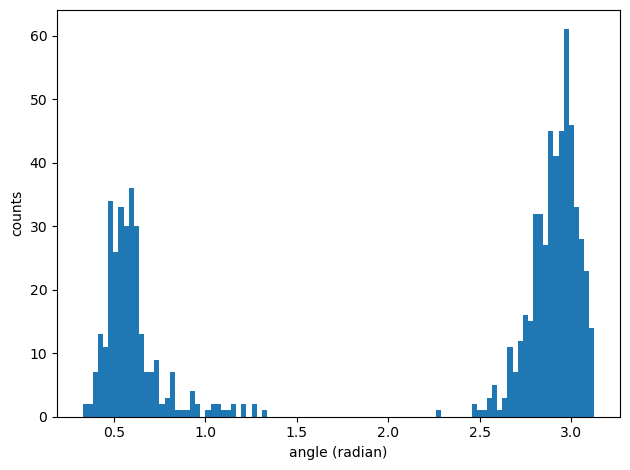

In [135]:
angles = []
hairpin_count = 0
extended_count = 0
for lipid in lipids:
    if lipid.name == 'ucer2':
        angles.append(lipid.angle)
        if lipid.is_hairpin:
            hairpin_count = hairpin_count + 1
        else:
            extended_count = extended_count + 1
            
# Note this included those at the water interface which will always be extended
print("% extended total: ",  100.0*extended_count/(extended_count+hairpin_count))       
        
n_bins=100
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

com_hist = axs.hist(angles, bins=n_bins)
axs.set_xlabel('angle (radian)')
axs.set_ylabel('counts')

## Using the bounds

Here we will use the bounds (spatial and hairpin vs. extended) to break up the system.  We can simply just loop over ther lipid class and build up lists of residue ids. 

We will create a function to make these easier to come up with custom ranges.

In [136]:
def breakup_system(lipids, z_min=0, z_max=20, inner_leaflets=True):
    extended = []
    hp = []
    chol = []
    ffa24 = []
    cer = []
    lipids_all = []
    
    for lipid in lipids:   
        #inner leaflets
        if inner_leaflets:
            if lipid.com[2] > z_min:
                if lipid.com[2] < z_max:
                    lipids_all.append(lipid.res_id)
                    if lipid.name == 'ucer2':
                        cer.append(lipid.res_id)
                        if lipid.is_hairpin == False:
                            extended.append(lipid.res_id)
                        else:
                            hp.append(lipid.res_id)
                    elif lipid.name == 'chol':
                        chol.append(lipid.res_id)
                    elif lipid.name == 'ffa24':
                        ffa24.append(lipid.res_id)
        #outer leaflets
        else: 
              if lipid.com[2] < z_min or lipid.com[2] > z_max:
                    lipids_all.append(lipid.res_id)
                    if lipid.name == 'ucer2':
                        cer.append(lipid.res_id)
                        if lipid.is_hairpin == False:
                            extended.append(lipid.res_id)
                        else:
                            hp.append(lipid.res_id)
                    elif lipid.name == 'chol':
                        chol.append(lipid.res_id)
                    elif lipid.name == 'ffa24':
                        ffa24.append(lipid.res_id)   
    return extended, hp, chol, ffa24, cer, lipids_all



In [140]:
#bounds for the central region
z_min = n_bounds_min[0] 
z_max = n_bounds_min[-1] 
# for good measure, print out the bounds we used above
print(z_min, z_max)

extended_inner, hp_inner, chol_inner, ffa24_inner, cer_inner, all_lipids_inner = breakup_system(
                                                                                    lipids, 
                                                                                    z_min, 
                                                                                    z_max, 
                                                                                    inner_leaflets=True)

extended_outer, hp_outer, chol_outer, ffa24_outer, cer_outer, all_lipids_outer = breakup_system(
                                                                                    lipids, 
                                                                                    z_min, 
                                                                                    z_max, 
                                                                                    inner_leaflets=False)

6.132457642627866 16.977548616226365


## Writing the index file

With these groups identified, we now need to generate the index file
* note, mdtraj operates under the assumption that the index starts at 0, but the index files for GROMACS start at 1. Hence, the topology select tool in mdtraj uses the info directly from the arrays determined above (i.e., starting from 0) , but needs to be written out +1 to work with GROMACS properly.

We will write a simple function since we will be doing the same thing over and over again with each group.


In [143]:
def write_index_entry(traj, lipid_selection, selection_name, output_file):
    output_file.write(f'[ {selection_name} ]\n')

    count = 1
    temp_str = ''
    for lipid in lipid_selection:
        center = traj.topology.select('resid ' + str(lipid))
        #print(center)
        for indy in center:
            temp_str = temp_str + str(indy+1)
            #make sure we don't put too many entries on a given line
            if count%15 == 0:
                temp_str = temp_str + "\n"
            else:
                temp_str = temp_str + " "
            count = count + 1
    output_file.write(temp_str)
    output_file.write('\n')


In [145]:
index_file = open("inner_index.ndx", "w") 

write_index_entry(traj, extended_inner, 'exCER_inner', index_file)
write_index_entry(traj, hp_inner, 'hpCER_inner', index_file)
write_index_entry(traj, chol_inner, 'chol_inner', index_file)
write_index_entry(traj, ffa24_inner, 'ffa24_inner', index_file)
write_index_entry(traj, cer_inner, 'cer_inner', index_file)

index_file.close()



We can now grab some of the code from the `simple_hond_calculation.ipynb` to automate the calculation. 

In [150]:
groups =!cat inner_index.ndx | grep '\['


#strip out the square brackets and space
for i,group in enumerate(groups):
    group = group.strip('[]')
    group = group.strip()
    groups[i] = group
    
print(groups)

stripped_group = []
for i in range(0, len(groups)):
    if 'Other' not in groups[i]:
        if 'System' not in groups[i]:
            if 'lipids' not in groups[i]:
                temp_group = {'name': groups[i], 'index':i}
                stripped_group.append(temp_group)
                
                

['exCER_inner', 'hpCER_inner', 'chol_inner', 'ffa24_inner', 'cer_inner']


In [152]:
# path to the trajectory file
traj_path = '../../4_prod_f305/trimmed_470.xtc'

# we need to tell us what tpr file to use
tpr_path = '../../4_prod_f305/run.tpr'

# we also need to know the location of the index file
ndx_path = 'inner_index.ndx'



In [153]:
filenames = []
for i in range(0, len(stripped_group)):
    for j in range(i, len(stripped_group)):
        index_i = stripped_group[i]['index']
        index_j = stripped_group[j]['index']
        name_i = stripped_group[i]['name']
        name_j = stripped_group[j]['name']
        print(index_i, index_j, '##', name_i, name_j)

        
        text_file = open(f'selection.txt', 'w')
        text_file.write(f'{index_i}\n{index_j}\n')
        text_file.close()

        output_file = f'hbond_{name_i}_{name_j}.xvg'
        filenames.append(output_file)
        msg = f'/usr/local/gromacs/bin/gmx hbond -f {traj_path} -s {tpr_path} -n {ndx_path} -num {output_file} < selection.txt'
        
        print(msg)
        !{msg}

0 0 ## exCER_inner exCER_inner
/usr/local/gromacs/bin/gmx hbond -f ../../4_prod_f305/trimmed_470.xtc -s ../../4_prod_f305/run.tpr -n test_index.ndx -num hbond_exCER_inner_exCER_inner.xvg < selection.txt
                      :-) GROMACS - gmx hbond, 2022.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/cri/Dropbox/Mac (3)/Documents/Projects/CER_reverse_mapped_v3_allext/analysis_scripts/hydrogen_bonding
Command line:
  gmx hbond -f ../../4_prod_f305/trimmed_470.xtc -s ../../4_prod_f305/run.tpr -n test_index.ndx -num hbond_exCER_inner_exCER_inner.xvg

Reading file ../../4_prod_f305/run.tpr, VERSION 2020.6 (single precision)
Note: file tpx version 119, software tpx version 127
Specify 2 groups to analyze:
Group     0 (    exCER_inner) has 65145 elements
Group     1 (    hpCER_inner) has  4128 elements
Group     2 (     chol_inner) has 20202 elements
Group     3 (    ffa24_inner) has 37518 elements
Group     4 (      cer_inner) has 69273

In [154]:
from os.path import exists

hbond_data = []
hbond_dict = []
for file in filenames:
    full_path = file
    breakdown = file.split('_')
    breakdown2 = breakdown[-1].split('.')

    
    header = ['time', 'hbonds', 'pairs']
    
    file_exists = exists(full_path)
    
    if file_exists:
        B = np.genfromtxt(full_path, names=header, dtype=None, skip_header=25) 

        data_dict = { "i": breakdown[0],
                      "j": breakdown[1],
                      "loc" :  breakdown2[0],
                      "hbonds" : [B[:]['hbonds']] }
        hbond_dict.append(data_dict)

        hbond_data.append(B)
       # print()
        print(file, '\t' , np.mean(B[:]['hbonds']), np.std(B[:]['hbonds']),  np.mean(B[:]['pairs']), 
              np.mean(B[:]['hbonds'])/ np.mean(B[:]['pairs']))

hbond_exCER_inner_exCER_inner.xvg 	 581.2323943661971 15.320825140944757 2785.8908450704225 0.20863430288185056
hbond_exCER_inner_hpCER_inner.xvg 	 53.95774647887324 5.2054592678502605 88.63732394366197 0.6087474675247289
hbond_exCER_inner_chol_inner.xvg 	 150.2394366197183 9.729025527295715 305.03521126760563 0.49253145561583744
hbond_exCER_inner_ffa24_inner.xvg 	 436.2992957746479 16.67391906448077 655.6901408450705 0.6654046913262017
hbond_hpCER_inner_hpCER_inner.xvg 	 3.1795774647887325 1.5854105405311822 112.03169014084507 0.028381054153439986
hbond_hpCER_inner_chol_inner.xvg 	 10.901408450704226 2.4112700737120445 20.95774647887324 0.5201612903225806
hbond_hpCER_inner_ffa24_inner.xvg 	 37.443661971830984 4.308564428557699 52.86267605633803 0.7083194564710583
hbond_chol_inner_chol_inner.xvg 	 0.1056338028169014 0.3294841567687207 0.49295774647887325 0.21428571428571427
hbond_chol_inner_ffa24_inner.xvg 	 82.58098591549296 5.653472485176406 156.47535211267606 0.5277571502509057
hbon